# CSE 6240 - Web Search & Text Mining - Homework 3

In [1]:
# __author__ = 'Bhanu Verma'
# GTid = '903151012'

In [2]:
import csv
import pprint
import math
import numpy as np
from scipy.optimize import fmin_bfgs
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def read_data(path, linear):
    x = []
    y = []
    x_n = []
    with open(path, 'r') as datafile:
        file_reader = csv.reader(datafile, delimiter=',')
        
        for row in file_reader:
            x_1 = float(row[0])
            x_2 = float(row[1])
            x.append((x_1,x_2))
            if (not linear):
                x_n.append((x_1, x_2, x_1*x_2, x_1*x_1, x_2*x_2))
            y.append(int(row[2]))
            
    if (linear):
        return x, y
    else:
        return x, x_n ,y

In [4]:
def get_sigmoid(theta, train_x):
    theta = np.reshape(theta,(len(theta),1))        # convert it to a column vector first
    z = np.dot(train_x,theta)                       # do matrix multiplication of the vectors
    den = 1.0 + math.e ** (-1.0 * z)                # calculate the denominator for the sigmoid
    sigmoid_val = 1.0/den
    
    return sigmoid_val

In [5]:
def get_h_theta(theta, train_x):
    h_theta_val = get_sigmoid(theta, train_x)
    
    return h_theta_val

In [6]:
def cost_function(theta, train_x, train_y, lambda_val = 0.0):
    training_size = float(train_x.shape[0])
    
    term_a = (1.0 * train_y) * np.log(get_h_theta(theta, train_x))
    term_b = (1.0 - train_y) * np.log(1.0 - get_h_theta(theta, train_x))
    cost = -(term_a + term_b)
    cost += (float(lambda_val) / (2.0 * training_size)) * np.sum(theta[1:]**2)
    
    for i in range(cost.size):
        if np.isnan(cost[i][0]):
            cost[i][0] = 0
        elif (cost[i][0] == np.inf):
            cost[i][0] = 10000
    
    cost = np.sum(cost) / training_size
    
    return cost

In [7]:
def gradient_function(theta, train_x, train_y, lambda_val):
    training_size = float(train_x.shape[0])
    delta_val = np.sum((get_h_theta(theta, train_x) - train_y) * train_x, axis=0)
    grad = (1.0 / training_size) * delta_val
    grad[1:] += (float(lambda_val) / training_size) * theta[1:]
    
    return grad

In [8]:
def run_optimization(train_x, train_y, lambda_val):
    training_size, dim_size = train_x.shape
    train_X = np.concatenate((np.ones((training_size, 1), dtype=float), train_x), axis=1)
    train_Y = train_y.reshape((training_size, 1))
    dim_size += 1                  # adjusting for theta zero
    theta = np.random.rand(dim_size, 1)
    optimized_theta = fmin_bfgs(cost_function, theta, fprime=gradient_function, args=(train_X,train_Y,lambda_val))
    
    return optimized_theta

In [9]:
def draw_scatter_plot(pos_data, neg_data, plotLabel, x_axis_label, y_axis_label,fig_no):
    plt.figure(fig_no, figsize=(10, 7))

    plt.subplot(1,1,1)
    plt.title(plotLabel)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)

    admit_axis_x = pos_data[:,[0]]
    admit_axis_y = pos_data[:,[1]]
    pos = plt.scatter(admit_axis_x, admit_axis_y, s=50, marker='+', color='green', alpha=0.8)

    reject_axis_x = neg_data[:,[0]]
    reject_axis_y = neg_data[:,[1]]
    neg = plt.scatter(reject_axis_x, reject_axis_y,s=50, marker='o', color='red', alpha=0.8)
    plt.legend((pos, neg),('Accepted', 'Not Accepted'),scatterpoints=1,loc='upper right',ncol=3,fontsize=12)
    plt.grid(True)
    plt.show()

In [10]:
def plot_decision_boundary(linear,pos_data, neg_data, plotLabel, x_axis_label, y_axis_label,fig_no,x_points,y_points,z):
    plt.figure(fig_no, figsize=(10, 7))

    plt.subplot(1,1,1)
    plt.title(plotLabel)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)

    admit_axis_x = pos_data[:,[0]]
    admit_axis_y = pos_data[:,[1]]
    pos = plt.scatter(admit_axis_x, admit_axis_y, s=50, marker='+', color='green', alpha=0.8)

    reject_axis_x = neg_data[:,[0]]
    reject_axis_y = neg_data[:,[1]]
    neg = plt.scatter(reject_axis_x, reject_axis_y,s=50, marker='o', color='red', alpha=0.8)
    plt.legend((pos, neg),('Accepted', 'Not Accepted'),scatterpoints=1,loc='upper right',ncol=3,fontsize=12)
    if (linear):
        plt.plot(x_points, y_points, linewidth=2.0)
    else:
        plt.contour(x_points, y_points, z, 1)
    plt.grid(True)
    plt.show()

In [11]:
def make_prediction(opt_theta, train_x_item):
    train_X_item = np.concatenate((np.ones(1, dtype=float), train_x_item))
    val = get_h_theta(opt_theta, train_X_item)
    
    if val >= 0.5:
        return 1
    else:
        return 0

In [12]:
def get_accuracy(optimized_theta, train_x):
    ind = 0
    success_count = 0
    for row in train_x:
        pred_val = make_prediction(optimized_theta,row)
        if pred_val == train_y[ind]:
            success_count += 1
        ind += 1

    accuracy = success_count/(float(train_y.shape[0]))
    
    return accuracy

# Question 1 for exam data

In [13]:
filePath = 'data/ex2data1.txt'
x, y = read_data(filePath, True)
train_x = np.array(x)
train_y = np.array(y).reshape((len(y),1))

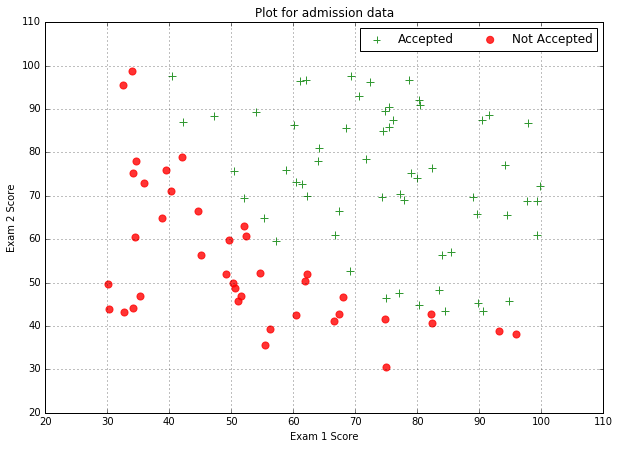

In [14]:
accept_x = []
reject_x = []
ind = 0
for row in train_y:
    if row[0] == 0:
        reject_x.append(train_x[ind])
    else:
        accept_x.append(train_x[ind])
    ind += 1
    
accept_x = np.array(accept_x)
reject_x = np.array(reject_x)
draw_scatter_plot(accept_x, reject_x, 'Plot for admission data', 'Exam 1 Score', 'Exam 2 Score',1)

As you can see from the plot above that a straight line can be used a decision boundary for this dataset and hence we can make do with only two theta parameters

In [15]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
optimized_theta = run_optimization(train_x, train_y, 1)

Optimization terminated successfully.
         Current function value: 0.203912
         Iterations: 26
         Function evaluations: 33
         Gradient evaluations: 33


In [17]:
print(optimized_theta)

[-25.05214083   0.20535442   0.20058348]


In [18]:
accuracy_score = get_accuracy(optimized_theta, train_x)
print("Accuracy for admission data: ", accuracy_score*100)

Accuracy for admission data:  89.0


In [19]:
x_points = np.array([min(train_x[:,[0]]),max(train_x[:,[0]])])
y_points = -1/optimized_theta[2] * (x_points * optimized_theta[1] + optimized_theta[0])

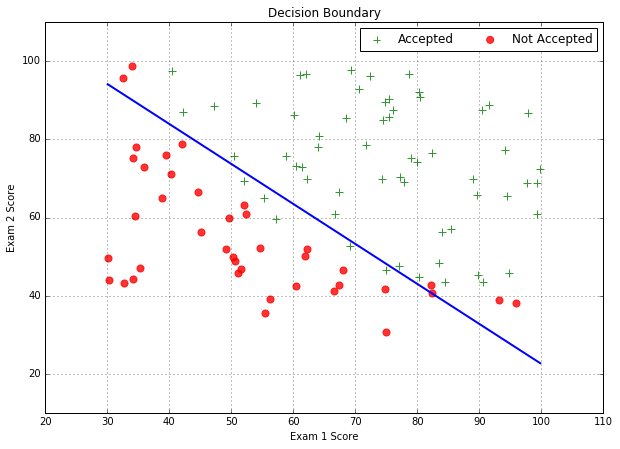

In [20]:
accept_x = []
reject_x = []
ind = 0
for row in train_y:
    if row[0] == 0:
        reject_x.append(train_x[ind])
    else:
        accept_x.append(train_x[ind])
    ind += 1
    
accept_x = np.array(accept_x)
reject_x = np.array(reject_x)
plot_decision_boundary(True,accept_x, reject_x, 'Decision Boundary', 'Exam 1 Score', 'Exam 2 Score',2, x_points, y_points, None)

# Question 1 for microchip data

In [21]:
filePath = 'data/ex2data2.txt'
x, x_n, y = read_data(filePath, False)
train_x = np.array(x)
train_X = np.array(x_n)
train_y = np.array(y).reshape((len(y),1))

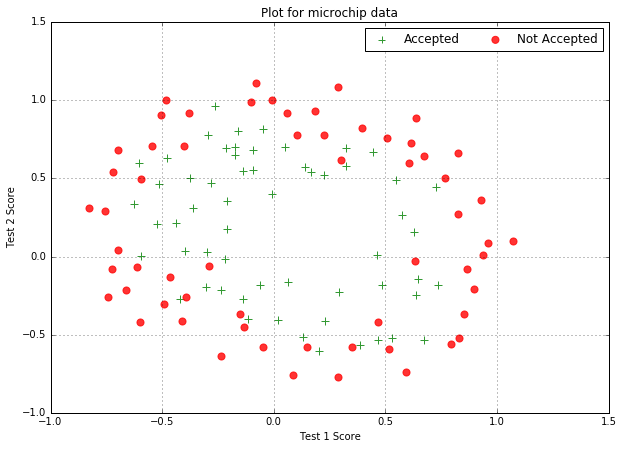

In [22]:
accept_x = []
reject_x = []
ind = 0
for row in train_y:
    if row[0] == 0:
        reject_x.append(train_x[ind])
    else:
        accept_x.append(train_x[ind])
    ind += 1
    
accept_x = np.array(accept_x)
reject_x = np.array(reject_x)

draw_scatter_plot(accept_x, reject_x, 'Plot for microchip data', 'Test 1 Score', 'Test 2 Score',3)

In [23]:
optimized_theta = run_optimization(train_X, train_y, 1)

Optimization terminated successfully.
         Current function value: 0.582863
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35


In [24]:
print(optimized_theta)

[ 1.19943715  0.35017009  0.67136998 -0.95703253 -2.78151108 -2.3903957 ]


In [25]:
accuracy_score = get_accuracy(optimized_theta, train_X)
print("Accuracy for microchip data: ", accuracy_score*100)

Accuracy for microchip data:  81.35593220338984


In [26]:
u = np.linspace(-1, 1.5, num=50)
v = np.linspace(-1, 1.5, num=50)
z = np.zeros((u.shape[0],v.shape[0]))
i = 0
for row_u in u:
    j = 0
    for row_v in v:
        new_theta = optimized_theta.reshape(optimized_theta.shape[0],1)
        z[i][j] = np.dot(np.array([1,u[i],v[j],u[i]*v[j],u[i]*u[i],v[j]*v[j]]),new_theta)
        j+=1
    i+=1
    
z = np.transpose(z)

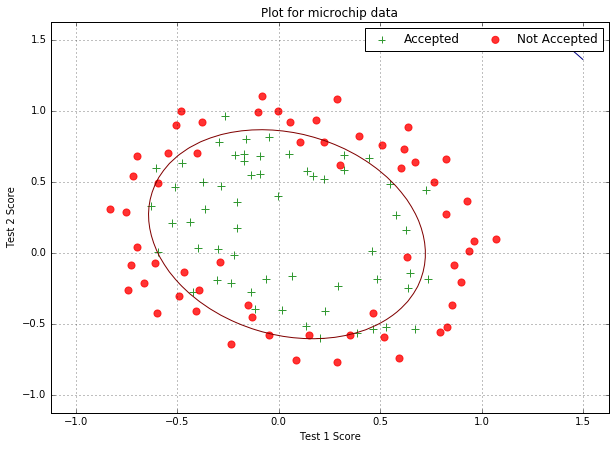

In [27]:
plot_decision_boundary(False,accept_x, reject_x, 'Plot for microchip data', 'Test 1 Score', 'Test 2 Score',4,u,v,z)